Студент: Преснова Анна, @Presnova4

## МАСТЕРСКАЯ 2 Мэтчинг товаров.  https://github.com/AnnaPresnova/Matching

## Задачи: 

1. разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

2. оценить качество алгоритма по метрике accuracy@5


# 1. Знакомство с данными

In [152]:
# импорт необходимых библиотек

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt 
from sklearn import preprocessing


In [153]:
# прочитаем файл base, в котором хранятся товары (колонка id) и их признаки (колонки с нумерацией от нуля и далее)

df_base = pd.read_csv(r"C:\Users\Анна\Documents\Проекты\Мастерская 2 Мэтчинг\data (1)\base.csv", index_col=0)

df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [154]:
# проверим размера датафрейма base 

df_base.shape

(2918139, 72)

Файл base состоит из векторов, количество которых более 2,9 млн с 72 признаками.

In [157]:
# прочитаем файл train, на котором будем подбирать параметры библиотеки Faiss, 
# которая понадобится для решения поставленной задачи 

df_train = pd.read_csv(r"C:\Users\Анна\Documents\Проекты\Мастерская 2 Мэтчинг\data (1)\train.csv", index_col=0)

display(df_train.head())

df_train.shape

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


(100000, 73)

Датасет train состоит из 100 000 векторов с 72 признаками и столбцом Target, в котором уже подобран наиболее подходящий товар из base.

# 2. Предобработка данных

Перед разработкой алгоритма обрботаем датафрейм base.

In [160]:
# проверим статистические значения данных датафрейма base


# для вывода таблицы в полном объеме использую 
# pd.set_option('display.max_rows', None)

df_base.describe().T


,count,mean,std,min,25%,50%,75%,max
0,2918139.0,-86.229474,24.891320,-199.468700,-103.065438,-86.231500,-69.256577,21.515549
1,2918139.0,8.080077,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.0,-44.580804,38.631660,-240.073400,-69.559490,-43.816605,-19.625266,160.937230
3,2918139.0,-146.634991,19.844805,-232.667140,-159.905060,-146.776810,-133.327655,-51.374780
4,2918139.0,111.316628,46.348090,-105.582960,80.507945,111.873000,142.374275,319.664500
5,2918139.0,-71.991376,28.186068,-211.008600,-91.379940,-71.922300,-52.441105,58.806244
6,2918139.0,-392.223854,271.654995,-791.469870,-629.331823,-422.201616,-156.668583,109.632533
7,2918139.0,20.352829,64.216382,-301.859740,-22.221474,20.804773,63.918212,341.228200
8,2918139.0,123.684234,6.356109,93.153046,119.483983,123.892250,127.970480,152.261200
9,2918139.0,124.458053,64.430576,-173.871950,81.767510,123.497696,167.220605,427.542050


При анализе статистических данных датафрейма base отметим столбцы, в которых возможны аномалии (выбросы). Если стандартное отклонение велико (то есть отношение стандартного отклонения к среднему больше единицы), речь может идти об аномалиях. Такие столбцы у нас следующие: 7, 13, 16, 17, 22, 24, 30,34, 36,41, 49, 50, 51, 57, 65. Построим диаграммы размаха.

<AxesSubplot:>

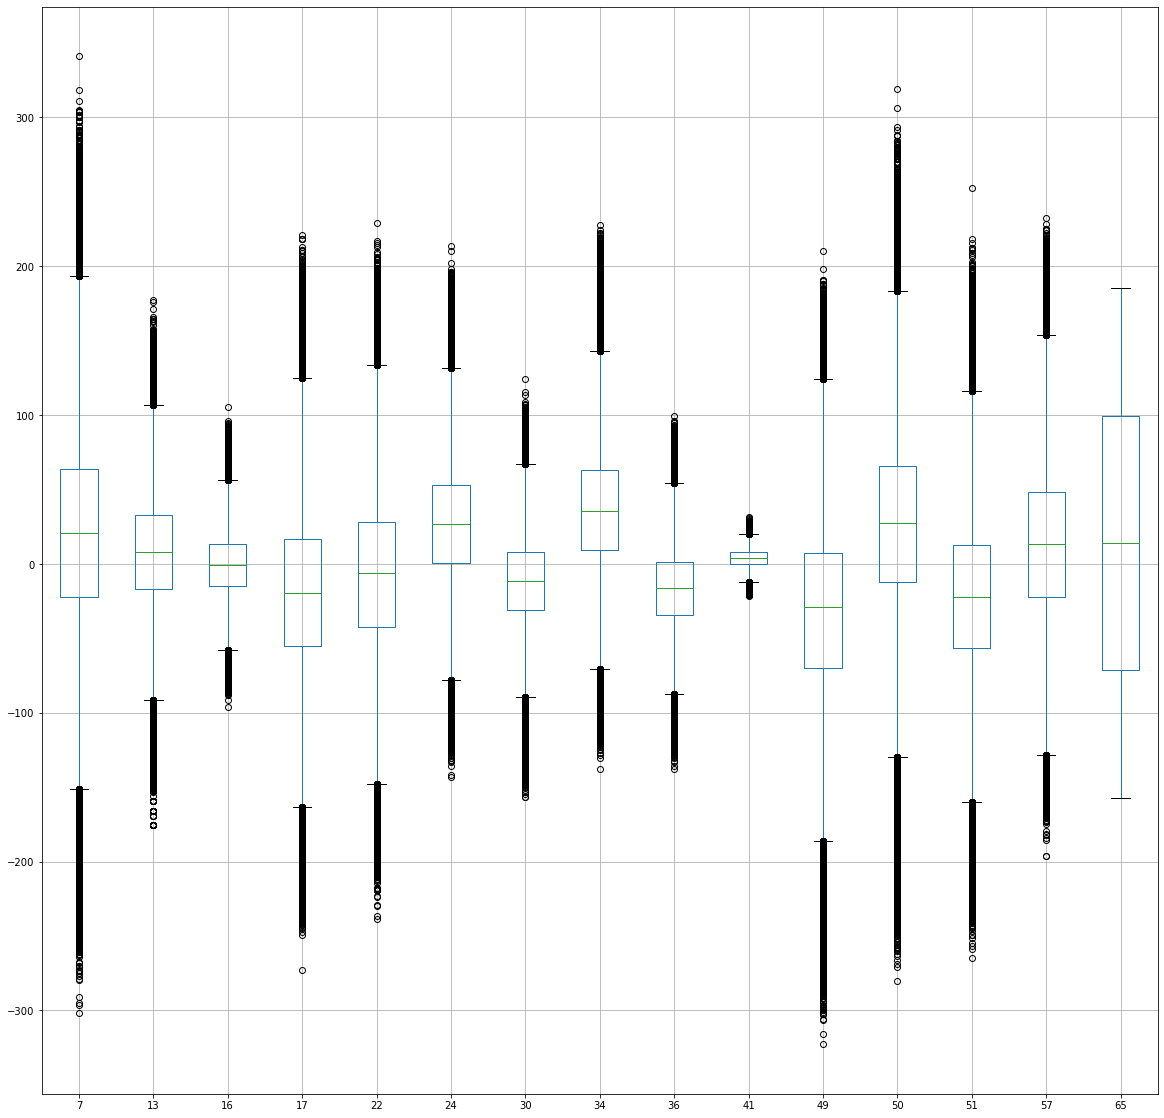

In [91]:
%matplotlib inline

plt.figure(figsize=(20, 20))

df_base.boxplot(column=['7', '13', '16', '17', '22', '24', '30', '34', '36', '41', '49', '50', '51', '57', '65'])



Во всех перечисленных столбцах, кроме столбца 65, действительно присутствуют аномальные значения. Будем от них избавляться.

In [161]:
# во всех перечисленных столбцах откинем данные, выходящие за пределы 

df_base = df_base[(df_base['7'] > -150) & (df_base['7'] < 200)]



<AxesSubplot:>

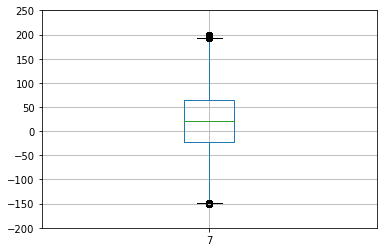

In [162]:
# проверим, как сработал код

plt.ylim(-200,250)

df_base.boxplot(column=['7'])

Аномальные значения в столбце 7 отброшены.

In [163]:
# проделаем то же самое с остальными столбцами

df_base = df_base[(df_base['13'] > -100) & (df_base['13'] < 100)]



In [164]:
df_base = df_base[(df_base['16'] > -50) & (df_base['16'] < 50)]

In [165]:
df_base = df_base[(df_base['17'] > -170) & (df_base['17'] < 130)]

In [166]:
df_base = df_base[(df_base['22'] > -150) & (df_base['22'] < 140)]

In [167]:
df_base = df_base[(df_base['24'] > -90) & (df_base['24'] < 130)]

In [168]:
df_base = df_base[(df_base['30'] > -100) & (df_base['30'] < 80)]

In [169]:
df_base = df_base[(df_base['34'] > -70) & (df_base['34'] < 140)]

In [170]:
df_base = df_base[(df_base['36'] > -100) & (df_base['36'] < 60)]

In [171]:
df_base = df_base[(df_base['41'] > -10) & (df_base['41'] < 20)]

In [172]:
df_base = df_base[(df_base['49'] > -200) & (df_base['49'] < 130)]

In [173]:
df_base = df_base[(df_base['50'] > -140) & (df_base['50'] < 200)]

In [174]:
df_base = df_base[(df_base['51'] > -170) & (df_base['51'] < 120)]

In [175]:
df_base = df_base[(df_base['57'] > -130) & (df_base['57'] < 150)]

Аномальные значения убраны.
При анализпе статистических значений обратили внимание, что у нас есть столбец 70, в котором среднее больше медианы, более, чем в 7 раз. Значит, возможен длинный хвост с высокими значениями или несколько очень больших значений. Построим гистограмму.

array([[<AxesSubplot:title={'center':'70'}>]], dtype=object)

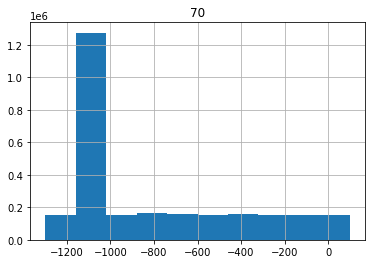

In [176]:
 # построим гистограмму по столбцу 70
    
df_base.hist (column='70')

Информация о наличии длинного хвоста с высокими значениями подтвердилась, распределение не соответствует нормальному. Необходимо будет провести нормализацию значений. 

Дополнительно посмотрим гистограммы по всем столбцам, и при наличии столбцов без нормального распределения, нормализуем их тоже.

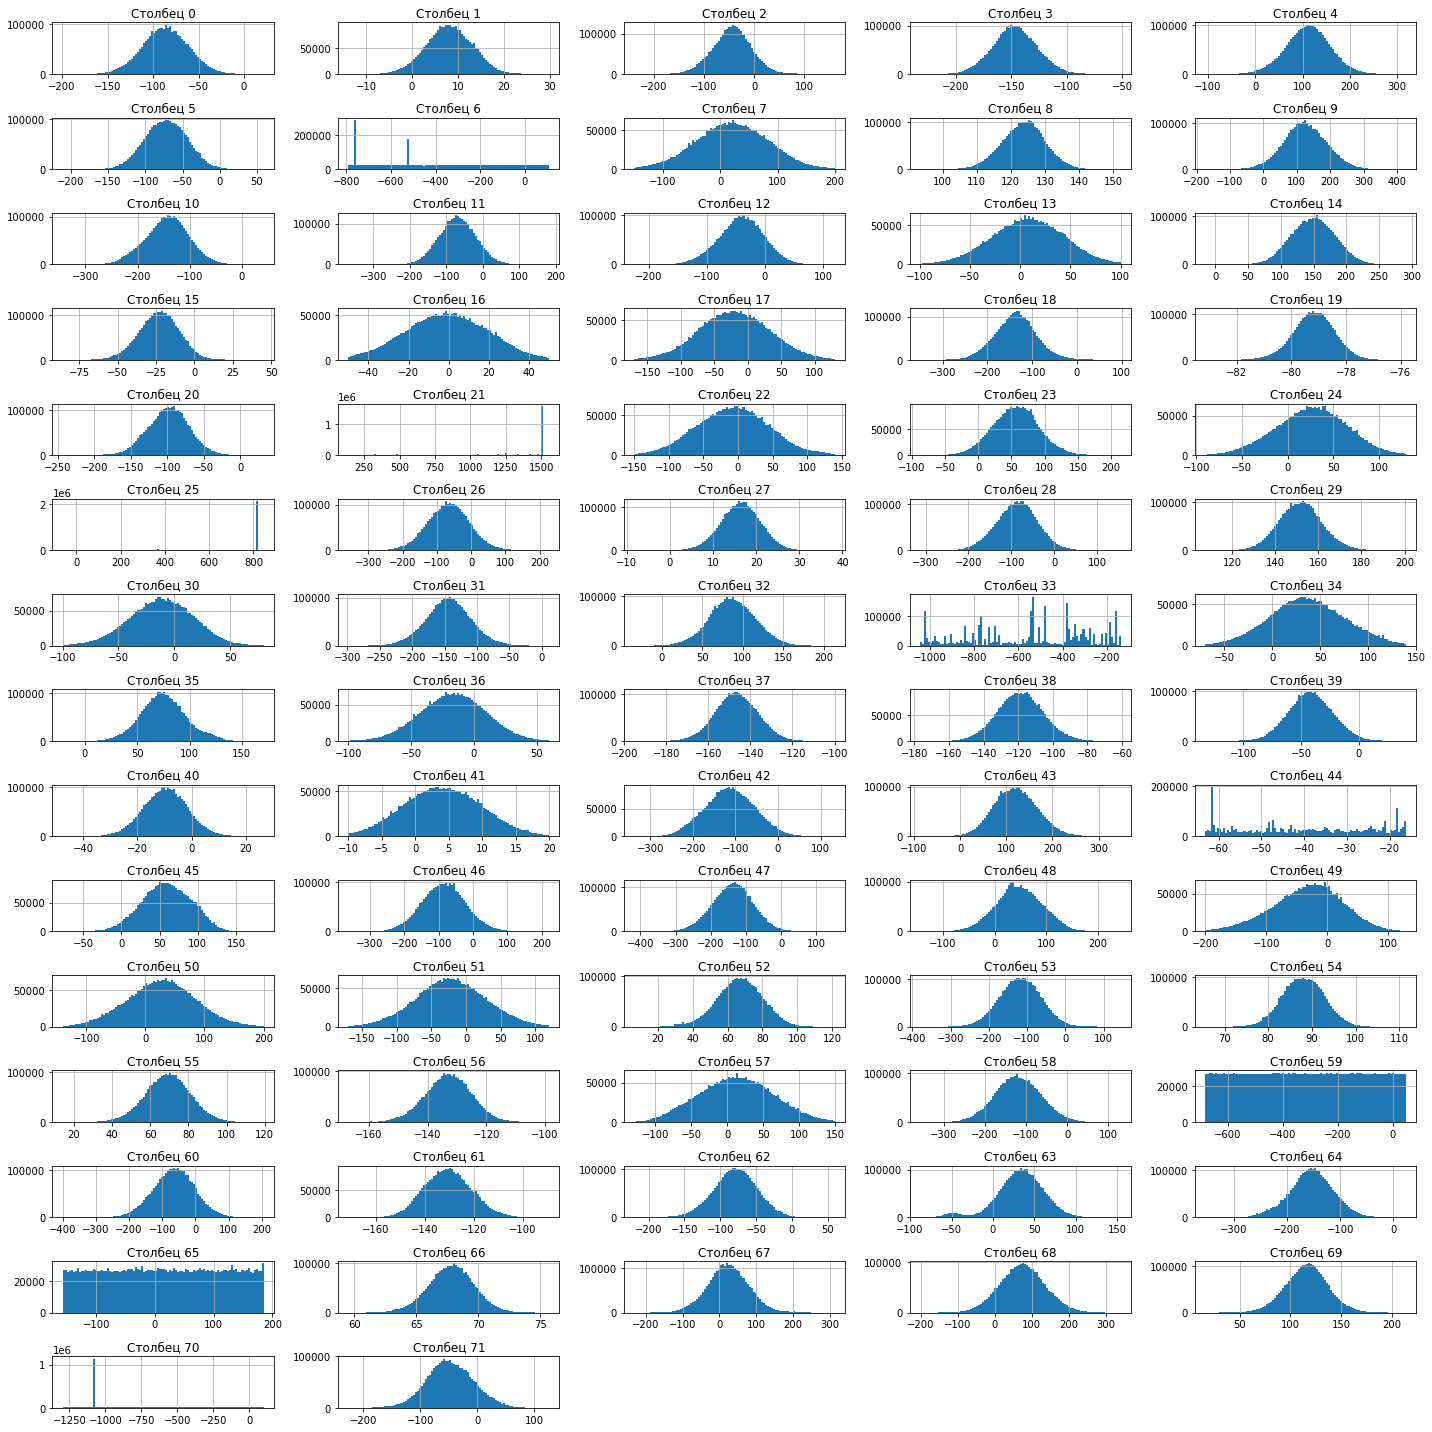

In [177]:
num_columns = df_base.shape[1]
num_rows = 15
num_cols = 5 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_columns:
        df_base.iloc[:, i].hist(bins=100, ax=ax)
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

Столбцы 6, 21, 25, 33, 44, 59, 65, 70 будем нормализовывать.

In [179]:
norm = ['6', '21', '25', '33', '44', '59', '65', '70']

df_base[norm] = preprocessing.normalize(df_base[norm], axis=0) 

# проверяем, как сработал код

df_base[norm].head()


,6,21,25,33,44,59,65,70
Id,,,,,,,,
0-base,-0.000600,0.000697,0.000658,-0.000537,-0.000828,0.000008,-0.000455,-0.000078
1-base,-0.000109,0.000199,0.000658,-0.000304,-0.000460,-0.000405,-0.000577,-0.000058
2-base,0.000067,0.000697,0.000658,-0.000781,-0.000673,-0.000851,0.000778,-0.000740
3-base,-0.000490,0.000684,0.000658,-0.000529,-0.000249,-0.000869,-0.000230,-0.000740
4-base,-0.000509,0.000584,0.000253,-0.000658,-0.000475,-0.000852,0.000525,-0.000740


Теперь можно приступать к разработке алгоритма.

# 3. Разработка алгоритма

In [181]:
# будем использовать библиотеку faiss с индексом IndexIVFFlat, 
# с помощью которого векторы из base будут разбиты на кластеры с центроидой во главе


# определим размер индексных векторов, равный количеству столбцов в base

dims = df_base.shape[1]

# определим количество кластеров/центроид

n_cells = 25 

# иницилиазируем квантователь - это индекс для присвоения векторов определенному кластеру

quantizer = faiss.IndexFlatL2(dims)

# определяем индекс

idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) 

# поиск будем вести по трем кластерам

idx_l2.nprobe = 3

In [182]:
#обучаем индекс для создания 25 кластеров

idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32')) 

# добавляем в кластеры соответствующие векторы

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [184]:
# индексы base переводим в счетчик, начинающийся с нуля

base_index = {k: v for k, v in enumerate(df_base.index.to_list())}



In [185]:
# датафрейм train тоже нормализуем

df_train[norm] = preprocessing.normalize(df_train[norm], axis=0) 

In [186]:
# запишем в переменную targets столбец с Target из train, при этом удалив из датафрейма train данный столбец

targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [187]:
# находим пять индексов (пять соседей) для train из  base

r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5) 

In [188]:
# проверяем качество алгоритма

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

62.087


Получаем accuracy@5, равное 0.62, результат удовлетворительный, переходим к применению алгоритма для поставленной задачи.

# 4. Применение разработанного алгоритма на validation, оценка качества.

In [191]:
# применим индекс для нахождения пяти ближайших соседей из base для каждого вектора валидационной выборки


# прочитаем валидационный файл

df_valid = pd.read_csv(r"C:\Users\Анна\Documents\Проекты\Мастерская 2 Мэтчинг\data (1)\validation.csv", index_col=0)
display(df_valid.head())

df_valid.shape



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


(100000, 72)

In [192]:
# нормализуем валидационный файл

df_valid[norm] = preprocessing.normalize(df_valid[norm], axis=0) 

In [193]:
# находим пять индексов (пять соседей) для valid из  base

r_val, idx_val = idx_l2.search(np.ascontiguousarray(df_valid.values).astype('float32'), 5)

In [194]:
# выведем на экран индексы пяти ближайших соседей из base для каждого товара validation

idx_val.head()

array([[2011449,  423168, 2298742,  338656,  914665],
       [1744587,  144446,  776052,   10825,  123739],
       [ 395212,  413613,  135687,   22847,  627580],
       ...,
       [1275904, 2521761, 1834044,  123474, 2064163],
       [ 292423, 2590197, 1733108, 2181660, 1922860],
       [1660926, 2653451,  783459, 2566217,  302849]], dtype=int64)

In [195]:
# для оценки качества будем использовать датафрейм df_valid_answer

df_valid_answer = pd.read_csv(r"C:\Users\Анна\Documents\Проекты\Мастерская 2 Мэтчинг\data (1)\validation_answer.csv", index_col=0)

display(df_valid_answer.head())

df_valid_answer.shape


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


(100000, 1)

In [150]:
# нам понадобится столбец с правильными ответами из df_valid_answer

targets_valid = df_valid_answer["Expected"]


In [196]:
# вычисляем метрику качества

acc = 0
for target, el in zip(targets_valid.values.tolist(), idx_val.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx_val))

61.818


Метрика почти такая же, как на датафрейме train. Алгоритм можно применять для поиска наиболее похожих товаров.

# 5. Вывод

Для выполнения задачи по разработке алгоритма, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base, мы использовали библиотеку faiss, которая позволяет быстро осуществить поиск ближайших соседей и кластеризацию в векторном пространстве.
Результат разработанного алгоритма мы оценили показателем accuracy@5, результат которого нас устроил.